Программа обработки сигналов акустической эмиссии. Программа использует данные, сформированные при циклическом испытании плоских образцов. Сиганлы акустической эмисии регистрировались двумя преобразователями, установленными на образце.

In [593]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Функция расчета значений временных интервалов между импульсами. Функция принимает столбец DataFrame, содержащий значения времени регистрации сигналов акустической эмиссии. Функция выдает столбец DataFrame, содержащий значения временных интервалов между сигналами акустической эмиссии.    

In [594]:
def delta_t(frame):
    frame.index = range(len(frame))
    duble_frame = frame.copy()
    del duble_frame[0]
    duble_frame.index = range(len(duble_frame))
    del frame[len(frame) - 1]
    delta_time = duble_frame - frame
    delta_time.index = range(1, len(frame) + 1)
    return delta_time

Функция расчета скользящей корреляции. Функция принимает столбец DataFrame. Функция выдает столбец DataFrame, содержащий значения коэффициента корреляции.

In [595]:
def corr_chart(data_01, data_02):
    change_01 = data_01.pct_change()
    change_02 = data_02.pct_change()
    return change_02.rolling(100, min_periods=5).corr(change_01)

Функция фильтрации выбросов. Функция принимает объект DataFrame и номер канала. Функция рассчитывает первый Q1 и третий квартиль Q3 и отбрасывает данные, превышающие верхнюю границу Q1 + 1.5(Q3-Q1). Функция возвращает объект DataFrame, очищенный от выбросов. 

In [596]:
def function_no_outlier(data, num_of_ch):
    first_quartile = data.loc[data['Number of channel'] == num_of_ch]['Interval'].quantile(0.25)
    third_quartile = data.loc[data['Number of channel'] == num_of_ch]['Interval'].quantile(0.75)
    Upper_limit = first_quartile + 1.5*(third_quartile - first_quartile)
    drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index
    data_no_outlier = data.drop(drop_index)
    return data_no_outlier

Считывание данных из текстового файла.

In [597]:
f = open(r'C:\Users\homepc\Documents\Pyton\aem09_01_13#02_AE.txt', 'r', encoding="utf-16")

Формирование объекта DataFrame из файла данных.

In [598]:
line = f.readline()  
s = []
col = ['Date', 'Time', 'mks', 'Time relative', 'Number of channel', 'Type', 'Amplitude, ADC', 'Amplitude, dB', 'Amplitude, mkV',
       'Amplitude/Counts, mkV', 'Ln(Amplitude)/Counts', 'Energy, J', 'Energy, dB', 'Energy MARSE', 'Duration', 'Rise time', 
       'Counts', 'Counts/Duration, kHz', 'Flags']
frame = pd.DataFrame(s, index = col)
i = 0
while line != '':
    s = line.split()
    frame[i] = s
    i += 1
    line = f.readline()
f.close()

Функция формирует строку, содержащую информацию о времени регистрации сигнала акустической эмиссии, суммируя текстовую информацию в стобцах 'Date', 'Time', 'mks'. Далее строка преобразуется в объект Datetime.  

In [599]:
def f(x):
    date = x[0] + ' ' + x[1] + '.' + x[2]
    return datetime.strptime(date, '%d.%m.%y %H:%M:%S.%f')

Формирование в столбце 'Time' объекта DataFrame данных о времени регистрации сигналов акустической эмиссии в формате Datetime. 

In [600]:
time = frame.apply(f)
data = frame.T
data['Time'] = time

Удаление из объекта DataFrame столбцов, содержащих информацию, не используемую в анализе

In [601]:
frame = data.drop(['Date', 'mks', 'Type', 'Flags'], axis = 1)

Расчет временных интервалов между сигналами акустической эмиссии для 1 и 2 каналов регистрации с помощью функции delta_t. Формирование объекта DataFrame, содержащего значения временных интервалов между сигналами. Индекс объекта DataFrame начинается со второго зарегистрированного сигнала.

In [602]:
f = lambda x: x.seconds + x.microseconds/1000000
data_t01 = delta_t(frame[frame['Number of channel'] == '01']['Time']).apply(f).to_frame(name = 'Interval')
data_t02 = delta_t(frame[frame['Number of channel'] == '02']['Time']).apply(f).to_frame(name = 'Interval')
data_t01.index = frame.loc[frame['Number of channel'] == '01'].index[1:]
data_t02.index = frame.loc[frame['Number of channel'] == '02'].index[1:]

Объединение данных с объектом DataFrame, содержащим значения временных интервалов между сигналами для 1 канала регистрации, запись в фрейм данных значений временных интервалов между сигналами для 2 канала регистрации

In [603]:
frame = pd.concat([frame, data_t01], axis = 1)
frame.loc[frame['Number of channel'] == '02', 'Interval'] = data_t02

Преобразование текстовых данных, содержащих информацию об амплитуде сигналов акустической эмиссии, в числовой формат

In [604]:
f1 = lambda x: float(x)
frame['Amplitude, dB'] = frame['Amplitude, dB'].apply(f1)

Удаление строк, содержащих выбросы в столбце 'Interval' с помощью функции function_no_outlier. Формирование нового объекта DataFrame, не содержащего строк с выбросами в столбце 'Interval'

In [605]:
frame_no_outlier_01 = function_no_outlier(frame, '01')
frame_no_outlier = function_no_outlier(frame_no_outlier_01, '02')

<ipython-input-596-d7fdc3f1adc5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index
<ipython-input-596-d7fdc3f1adc5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index


Построение графика изменения значений временных интервалов между сигналами акустической эмиссии от времени для каждого канала

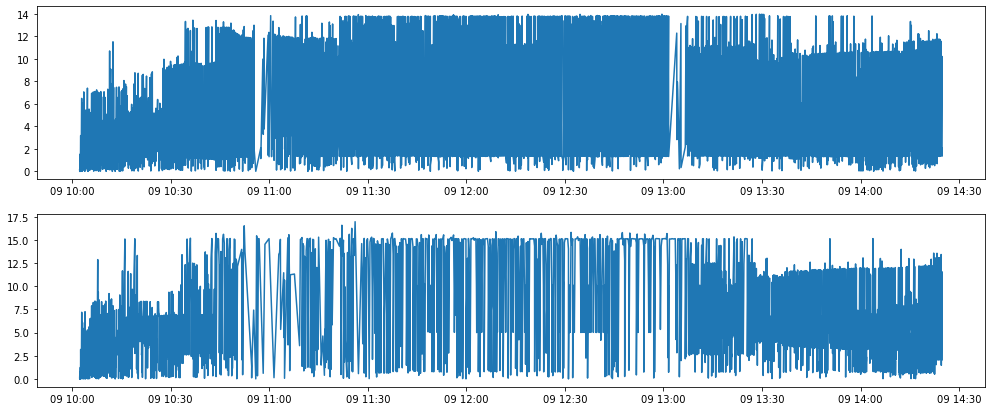

In [606]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Time'], 
         frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'])
ax2.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Time'], 
         frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'])

Построение графика корреляции между значениями интервалов между сигналами акустической эмиссии и амплитудой сигналов для каждого канала для объекта DataFrame, не содержащего выбросы, и полного объекта DataFrame

<ipython-input-607-4d45c8cf8b16>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2, 1, 1)
<ipython-input-607-4d45c8cf8b16>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(2, 1, 2)


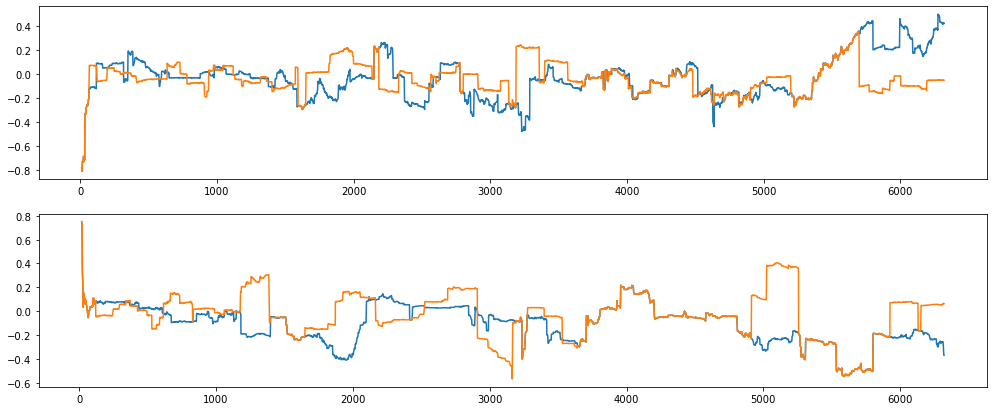

In [607]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(corr_chart(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'],
                   frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Amplitude, dB']))
ax2.plot(corr_chart(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'],
                   frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Amplitude, dB']))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(corr_chart(frame.loc[frame['Number of channel'] == '01']['Interval'],
                   frame.loc[frame['Number of channel'] == '01']['Amplitude, dB']))
ax2.plot(corr_chart(frame.loc[frame['Number of channel'] == '02']['Interval'],
                   frame.loc[frame['Number of channel'] == '02']['Amplitude, dB']))

Построение графика зависимости значений временных интервалов между сигналами акустической эмиссии от амплитуды сигналов для каждого канала

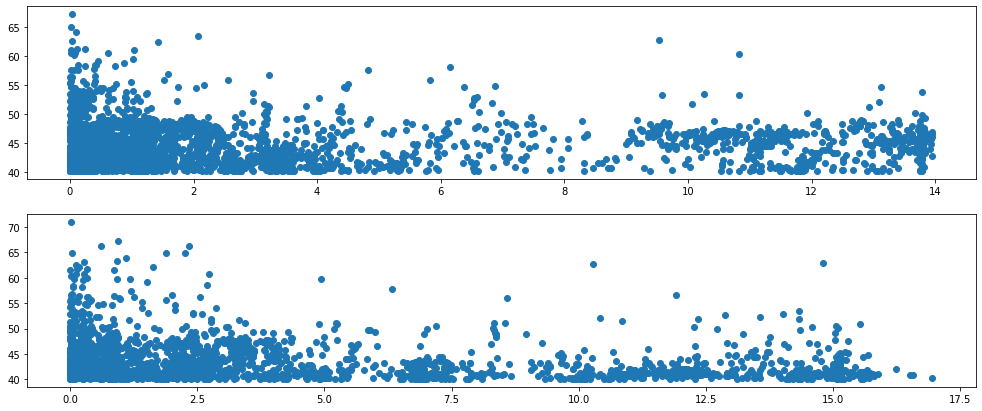

In [608]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Amplitude, dB'])
ax2.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Amplitude, dB'])

Построение графика зависимости значений временных интервалов между сигналами акустической эмиссии от амплитуды сигналов для каждого канала для объекта DataFrame, не отфильтрованного по выбрасам в столбце 'Interval'

(-5.0, 20.0)

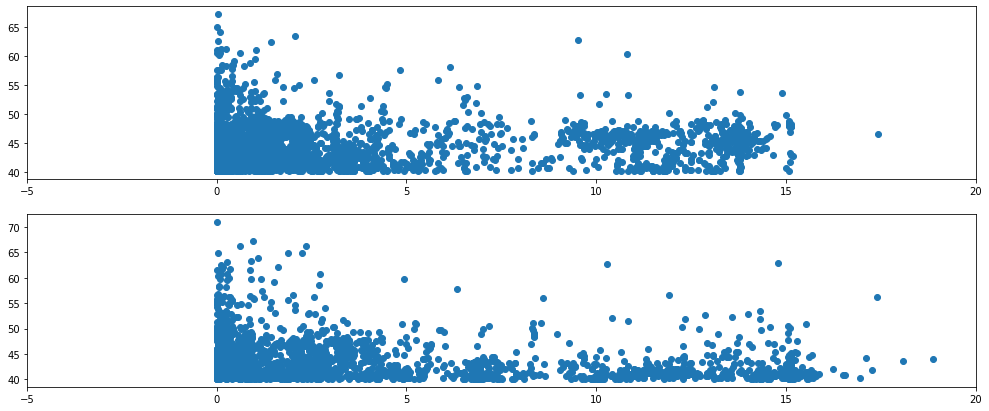

In [609]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.scatter(frame.loc[frame['Number of channel'] == '01']['Interval'], 
           frame.loc[frame['Number of channel'] == '01']['Amplitude, dB'])
ax1.set_xlim([-5, 20])
ax2.scatter(frame.loc[frame['Number of channel'] == '02']['Interval'], 
           frame.loc[frame['Number of channel'] == '02']['Amplitude, dB'])
ax2.set_xlim([-5, 20])

Построение графика распределения значений интервалов между сигналами акустической эмиссии

(array([916., 456., 244.,  75., 134., 102., 130., 167., 363.,  36.]),
 array([6.49000000e-04, 1.69597220e+00, 3.39129540e+00, 5.08661860e+00,
        6.78194180e+00, 8.47726500e+00, 1.01725882e+01, 1.18679114e+01,
        1.35632346e+01, 1.52585578e+01, 1.69538810e+01]),
 <BarContainer object of 10 artists>)

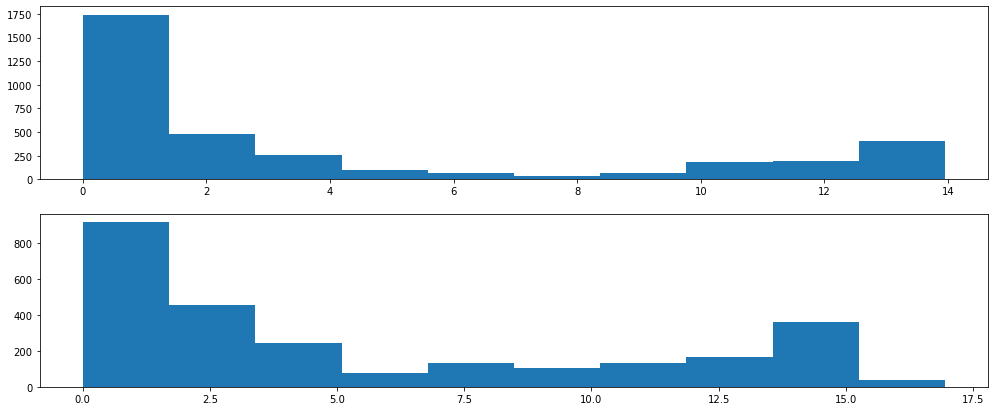

In [610]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.hist(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'])
ax2.hist(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'])

Построение графика изменения значения временного инварианта от времени для отфильтрованного по выбросам объекта DataFrame. Временной инвариант - это отношение стандартного отклонения временных интервалов между сигналами акустической эмиссии к их среднему значению. Для пуассоновского потока актов акустической эмиссии временной интервал имеет устойчивое значение, равное 1.

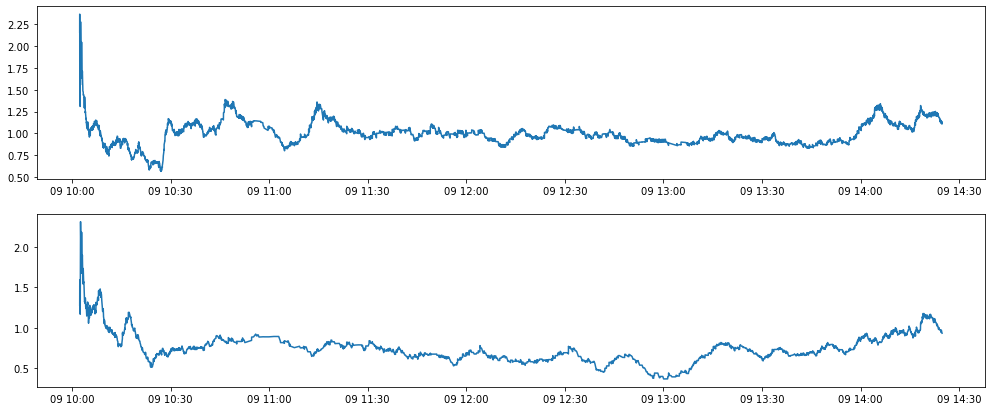

In [611]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Time'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'].rolling(50).std()/
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'].rolling(50).mean())
ax2.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Time'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'].rolling(50).std()/
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'].rolling(50).mean())

Построение графика изменения значения временного инварианта от времени для не отфильтрованного по выбросам объекта DataFrame. 

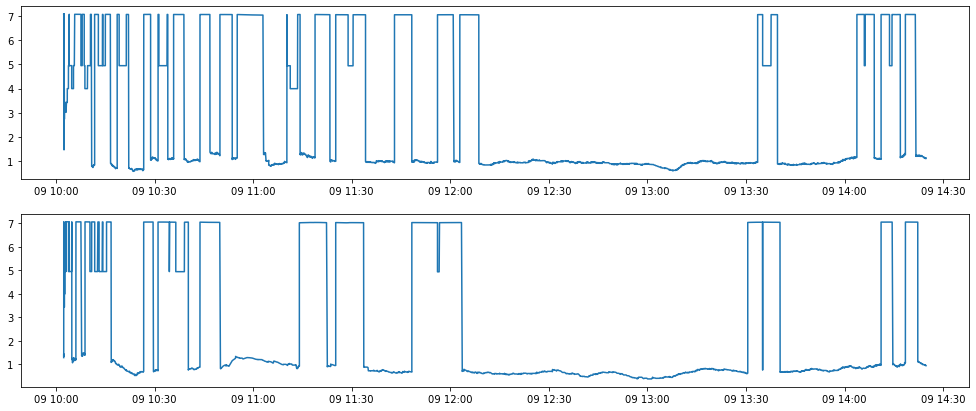

In [612]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(frame.loc[frame['Number of channel'] == '01']['Time'], 
           frame.loc[frame['Number of channel'] == '01']['Interval'].rolling(50).std()/
           frame.loc[frame['Number of channel'] == '01']['Interval'].rolling(50).mean())
ax2.plot(frame.loc[frame['Number of channel'] == '02']['Time'], 
           frame.loc[frame['Number of channel'] == '02']['Interval'].rolling(50).std()/
           frame.loc[frame['Number of channel'] == '02']['Interval'].rolling(50).mean())